## 1. Loading Required Packages

In [1]:
# Standard libraries
import sys
sys.path.append('../../')

import itertools

# Data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# FinRL and stable_baselines3 for machine learning and trading
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_primo_trading.env_primo_default import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from stable_baselines3.common.logger import configure

# Configuration files and helper functions from FinRL
from finrl.config import INDICATORS
from finrl.main import check_and_make_directories

# Enabling chart display within Jupyter notebook
%matplotlib inline

TRAINED_MODEL_DIR = 'files/models_PORTFOLIO'
RESULTS_DIR = 'files/results_PORTFOLIO'
DATA_DIR = 'files/data_PORTFOLIO'

# Checking and creating directories
check_and_make_directories([TRAINED_MODEL_DIR, DATA_DIR])

## 2. Data Retrieval

In [2]:
# Training and trading intervals
TRAIN_START_DATE = '2022-04-01'
TRAIN_END_DATE = '2024-07-31'
TRADE_START_DATE = '2024-08-01'
TRADE_END_DATE = '2025-02-28'

In [3]:
# Fetching all data
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                         end_date = TRADE_END_DATE,
                         ticker_list = ["AAPL", "NFLX", "MSFT", "CRM", "AMZN"]).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (3645, 8)


In [4]:
df_raw.head()

,date,open,high,low,close,volume,tic,day
0,2022-04-01,171.530609,174.309998,174.880005,174.029999,78751300,AAPL,4
1,2022-04-01,163.559998,163.559998,165.826996,164.149506,57090000,AMZN,4
2,2022-04-01,211.071075,212.250000,214.029999,212.479996,6007900,CRM,4
3,2022-04-01,301.616882,309.420013,310.130005,309.369995,27110500,MSFT,4
4,2022-04-01,373.470001,373.470001,380.869995,376.799988,4644200,NFLX,4


## 3. Data Processing

In [5]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_raw)

Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (728, 8)
Successfully added vix


Successfully added turbulence index


In [6]:
# Creates a list of unique stock tickers from the 'tic' column of the 'processed' DataFrame.
list_ticker = processed["tic"].unique().tolist()

# Creates a list of dates between the earliest and latest dates in the 'processed' DataFrame, converting them to strings.
list_date = list(pd.date_range(processed['date'].min(), processed['date'].max()).astype(str))

# Creates combinations of all dates and stock tickers using the Cartesian product.
combination = list(itertools.product(list_date, list_ticker))

# Creates a new DataFrame 'processed_full' with columns "date" and "tic", containing all combinations of dates and stock tickers.
# Merges this DataFrame with the original 'processed' DataFrame based on the "date" and "tic" columns, using a 'left' join.
processed_full = pd.DataFrame(combination, columns=["date", "tic"]).merge(processed, on=["date", "tic"], how="left")

# Filters the 'processed_full' DataFrame to contain only those rows whose dates are present in the original 'processed' DataFrame.
processed_full = processed_full[processed_full['date'].isin(processed['date'])]

# Sorts the 'processed_full' DataFrame by date and stock ticker.
processed_full = processed_full.sort_values(['date', 'tic'])

# Replaces all missing values (NaN) with 0 in the 'processed_full' DataFrame.
processed_full = processed_full.fillna(0)

In [7]:
processed_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2022-04-01,AAPL,171.530609,174.309998,174.880005,174.029999,78751300.0,4.0,0.0,175.06369,173.536316,100.0,66.666667,100.0,174.029999,174.029999,20.620001,0.0
1,2022-04-01,AMZN,163.559998,163.559998,165.826996,164.149506,57090000.0,4.0,0.0,175.06369,173.536316,100.0,66.666667,100.0,164.149506,164.149506,20.620001,0.0
2,2022-04-01,CRM,211.071075,212.250000,214.029999,212.479996,6007900.0,4.0,0.0,175.06369,173.536316,100.0,66.666667,100.0,212.479996,212.479996,20.620001,0.0
3,2022-04-01,MSFT,301.616882,309.420013,310.130005,309.369995,27110500.0,4.0,0.0,175.06369,173.536316,100.0,66.666667,100.0,309.369995,309.369995,20.620001,0.0
4,2022-04-01,NFLX,373.470001,373.470001,380.869995,376.799988,4644200.0,4.0,0.0,175.06369,173.536316,100.0,66.666667,100.0,376.799988,376.799988,20.620001,0.0


In [8]:
# Preparing the training and trade set according to the defined dates
train = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE, TRADE_END_DATE)
print(len(train))
print(len(trade))

2920
715


In [9]:
# Saving the data
train.to_csv('train_data.csv')
trade.to_csv('trade_data.csv')

## 4. Preparing the environment

In [10]:
# Calculating the dimension (number of unique stocks) from the 'train' DataFrame.
stock_dimension = len(train.tic.unique())

# Calculating the size of the state based on the dimension and the number of technical indicators.
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 5, State Space: 51


In [11]:
# Creates lists of buy and sell costs for each stock.
buy_cost_list = sell_cost_list = [0] * stock_dimension

# Initializes the number of shares for each stock to 0.
num_stock_shares = [0] * stock_dimension

In [12]:
# Define arguments for the trading environment.
env_kwargs = {
    "hmax": 1000,  # Maximum number of shares that can be bought or sold in a single transaction.
    "initial_amount": 100000,  # Initial amount of capital.
    "num_stock_shares": num_stock_shares,  # Initial number of shares for each stock in the portfolio, initially set to 0.
    "buy_cost_pct": buy_cost_list,  # Percentages of costs for buying and selling stocks, simulating actual transaction costs.
    "sell_cost_pct": sell_cost_list,  # Percentages of costs for buying and selling stocks, simulating actual transaction costs.
    "state_space": state_space,  # Previously defined sizes that affect the structure of the environment.
    "stock_dim": stock_dimension,  # Previously defined sizes that affect the structure of the environment.
    "tech_indicator_list": INDICATORS,  # List of technical indicators to be used for market state analysis.
    "action_space": stock_dimension,  # Size of the action space, i.e., the number of different actions the model can take.
    "reward_scaling": 1e-2  # Scaling factor for the reward, used to adjust the reward size to facilitate learning.
}

# Create the training environment.
e_train_gym = StockTradingEnv(df = train, **env_kwargs)

# Retrieve the environment suitable for Stable Baselines and the unused object.
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


## 5. Training DRL Agents

In [13]:
# Create an instance of the DRL agent with the provided training environment.
agent = DRLAgent(env = env_train)

# Set the appropriate values to 'True' for the algorithms you want to use
if_using_a2c = True
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = True

### Training 5 different DRL agents (A2C, DDPG, PPO, TD3, SAC)

#### Agent 1: A2C

In [14]:
# A new instance of the DRL agent is created with the provided environment (it is not necessary to do this again, but for easier instructions, it remains)
agent = DRLAgent(env = env_train)
# Retrieves the A2C model using the get_model method
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # Setting up the logger to monitor and record information during training
  tmp_path = RESULTS_DIR + '/a2c'
  # Configures a new logger that will print information to standard output, save to a CSV file, and TensorBoard
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Sets the new logger for the A2C model.

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to files/results_PORTFOLIO/a2c


In [15]:
# Train the A2C model with the defined total number of time steps, only if if_using_a2c is set to True.
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000) if if_using_a2c else None

--------------------------------------
| time/                 |            |
|    fps                | 1029       |
|    iterations         | 100        |
|    time_elapsed       | 0          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -7.13      |
|    explained_variance | 0.0182     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | 102        |
|    reward             | -17.095575 |
|    std                | 1.01       |
|    value_loss         | 429        |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 975        |
|    iterations         | 200        |
|    time_elapsed       | 1          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -7.14      |
|    explained_variance | -0.044     |
|    learning_rate      |

In [16]:
# Save the trained A2C model to the specified directory, only if if_using_a2c is set to True.
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

#### Agent 2: DDPG

In [17]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [18]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

In [19]:

trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

#### Agent 3: PPO

In [20]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to files/results_PORTFOLIO/ppo


In [21]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=400000) if if_using_ppo else None

day: 583, episode: 90
begin_total_asset: 100000.00
end_total_asset: 170495.35
total_reward: 70495.35
total_cost: 0.00
total_trades: 1950
Sharpe: 0.878
---------------------------------
| time/              |          |
|    fps             | 1888     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
| train/             |          |
|    reward          | 8.470789 |
---------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1548        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008009977 |
|    clip_fraction        | 0.0881      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.1        |
|    explained_variance   | 0.000462    |
|    learning_rate        | 0.00025    

In [22]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

#### Agent 4: TD3

In [23]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [24]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

In [25]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

#### Agent 5: SAC

In [26]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to files/results_PORTFOLIO/sac


In [27]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None

---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 196      |
|    time_elapsed    | 11       |
|    total_timesteps | 2336     |
| train/             |          |
|    actor_loss      | 0.082    |
|    critic_loss     | 370      |
|    ent_coef        | 0.122    |
|    ent_coef_loss   | 27.6     |
|    learning_rate   | 0.0001   |
|    n_updates       | 2235     |
|    reward          | 8.161451 |
---------------------------------
day: 583, episode: 780
begin_total_asset: 100000.00
end_total_asset: 152622.67
total_reward: 52622.67
total_cost: 0.00
total_trades: 1395
Sharpe: 0.681
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 182        |
|    time_elapsed    | 25         |
|    total_timesteps | 4672       |
| train/             |            |
|    actor_loss      | 43.9       |
|    critic_loss     | 528        |
|    ent_coef 

In [28]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## 6. Preparation for backtest

In [29]:
# If necessary, we load the saved data if we have restarted the process (not required)
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [30]:
# If necessary, we load the saved training data if we have restarted the process (not required)
if_using_a2c = True
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = True

trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## 7. Trading (data outside the training set)

In [31]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 5, State Space: 51


In [32]:
buy_cost_list = sell_cost_list = [0] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 1000,
    "initial_amount": 100000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-2
}

In [33]:
# Initialization of the trading environment with the defined DataFrame 'trade', turbulence threshold, and risk indicator 'vix',
# along with other environment parameters ('env_kwargs').
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

# Fetching the environment compatible with Stable Baselines and the initial observations.
env_trade, obs_trade = e_trade_gym.get_sb_env()

In [34]:
# Using the DRL agent for prediction using the trained model 'trained_a2c' and the defined trading environment 'e_trade_gym'.
# The results are two DataFrames: 'df_account_value_a2c' with account values and 'df_actions_a2c' with actions taken,
# if 'if_using_a2c' is set to True; otherwise, it returns (None, None).
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)

hit end!


In [35]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)

In [36]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)

hit end!


In [37]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else (None, None)

In [38]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)

hit end!


## 8. Mean Variance Optimization

In [39]:
# Function to prepare the DataFrame for calculating weights for mean variance optimization (MVO)
def process_df_for_mvo(df):
  # Sorts the DataFrame by date and stock ticker, then selects only relevant columns
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  # Takes a subset of data for the first dimension of stocks
  fst = df.iloc[0:stock_dimension, :]
  # Extracts the list of stock tickers
  tic = fst['tic'].tolist()

  # Initializes an empty DataFrame for MVO
  mvo = pd.DataFrame()

  # Sets initial weight values to 0 for each stock
  for k in range(len(tic)):
    mvo[tic[k]] = 0

  # Fills the 'mvo' DataFrame with closing prices for each stock by dates
  for i in range(df.shape[0]//stock_dimension):
    n = df.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()
  
  return mvo

In [40]:
# Function to calculate stock returns based on their prices
def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  # Initializes the return matrix.
  StockReturn = np.zeros([Rows-1, Columns]) 
  # Calculates daily return for each stock
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):       # i: Daily Prices 
      StockReturn[i,j] = ((StockPrice[i+1, j] - StockPrice[i,j]) / StockPrice[i,j]) * 100 
      
  return StockReturn

In [41]:
# Applying the function to training and trade
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

# Converts TradeData to a numpy array
TradeData.to_numpy()

array([[ 224.36999512,  189.28999329,  259.8999939 ,  420.79000854,
         629.25      ],
       [ 219.1499939 ,  166.75      ,  247.78999329,  412.48999023,
         620.97998047],
       [ 199.08999634,  154.21000671,  232.32000732,  389.17001343,
         587.03997803],
       [ 205.30000305,  161.71000671,  241.08999634,  400.        ,
         600.61999512],
       [ 206.8999939 ,  166.55000305,  242.61000061,  408.64001465,
         616.07000732],
       [ 213.11000061,  165.16999817,  243.24000549,  402.44000244,
         621.98999023],
       [ 212.1000061 ,  166.3999939 ,  248.69999695,  404.02999878,
         622.98999023],
       [ 216.07000732,  168.13999939,  252.6000061 ,  407.05999756,
         631.        ],
       [ 219.00999451,  167.80999756,  253.        ,  409.58999634,
         638.55999756],
       [ 220.57000732,  172.11000061,  255.38999939,  414.79998779,
         648.70001221],
       [ 224.6000061 ,  174.86000061,  257.8999939 ,  419.79998779,
         668

In [42]:
# Calculates returns per asset
arStockPrices = np.asarray(StockData)
[Rows, Cols] = arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

# Calculates average returns and the covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
# Sets precision for printing results.
np.set_printoptions(precision=3, suppress = True)

# Displays average returns and the covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.055 0.05  0.065 0.071 0.13 ]
Variance-Covariance matrix of returns
 [[3.042 2.356 1.884 1.843 2.037]
 [2.356 5.98  3.237 2.787 2.975]
 [1.884 3.237 6.1   2.237 2.447]
 [1.843 2.787 2.237 2.997 2.038]
 [2.037 2.975 2.447 2.038 8.125]]


### Now we use PyPortfolioOpt

In [43]:
# Loading the EfficientFrontier class from the PyPortfolioOpt library
from pypfopt.efficient_frontier import EfficientFrontier

# Initializing the EfficientFrontier object with average returns and the covariance matrix of returns
# Weight constraints are set so that no asset can constitute more than 50% of the portfolio
ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))

# Calculating raw weights for the maximum Sharpe ratio
raw_weights_mean = ef_mean.max_sharpe()

# Cleaning weights to round very small weights to 0 and normalize the others
cleaned_weights_mean = ef_mean.clean_weights()

# Converting cleaned weights to actual investment amounts, assuming an initial capital of 1,000,000
mvo_weights = np.array([100000 * cleaned_weights_mean[i] for i in range(5)])
print(mvo_weights)

# Calculating the last stock price in the dataset to determine the initial quantities of stocks.
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])

# Calculating the initial portfolio by multiplying the investment amounts with the last price.
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
print(Initial_Portfolio)

# Calculating the portfolio value using trade data and initial stock quantities.
Portfolio_Assets = TradeData @ Initial_Portfolio

# Creating a DataFrame with the results of the mean-variance optimization.
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
print(MVO_result)

(CVXPY) Mar 26 09:04:33 PM: Encountered unexpected exception importing solver ECOS:
ImportError("dlopen(/opt/miniconda3/lib/python3.12/site-packages/_ecos.cpython-312-darwin.so, 0x0002): tried: '/opt/miniconda3/lib/python3.12/site-packages/_ecos.cpython-312-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e' or 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/opt/miniconda3/lib/python3.12/site-packages/_ecos.cpython-312-darwin.so' (no such file), '/opt/miniconda3/lib/python3.12/site-packages/_ecos.cpython-312-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e' or 'arm64'))")
(CVXPY) Mar 26 09:04:33 PM: Encountered unexpected exception importing solver ECOS_BB:
ImportError("dlopen(/opt/miniconda3/lib/python3.12/site-packages/_ecos.cpython-312-darwin.so, 0x0002): tried: '/opt/miniconda3/lib/python3.12/site-packages/_ecos.cpython-312-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', ne

## 9. DJI index for comparison

In [44]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['^DJI']).fetch_data()

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (144, 8)


In [45]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(100000), 
               how='outer', left_index=True, right_index=True).set_index('date')

## 10. Running the backtesting model

In [46]:
# Setting the index of the DataFrames for account values for each of the DRL strategies, if selected.
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None

# Creating an empty DataFrame for results.
result = pd.DataFrame()

# Merging the results of all DRL strategies into one DataFrame, if selected.
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))

# Merging the mean-variance optimization results and the DJIA index with the main results.
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_22359/3791775406.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')


In [47]:
# Adding column names based on selected strategies.
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None
col_name.append('Mean Var')
col_name.append('DJI') 
result.columns = col_name

In [48]:
# Displaying the results
result.head()

,A2C,PPO,SAC,Mean Var,DJI
date,,,,,
2024-08-01,100000.000000,100000.000000,100000.000000,99256.126281,100000.000000
2024-08-02,98625.716934,88098.883545,98685.036896,97534.227504,97943.071056
2024-08-05,93052.242477,81477.767090,92527.982483,91904.120491,95452.327131
2024-08-06,95640.609268,85437.767090,96018.438110,94298.113186,94670.322190
2024-08-07,97705.572769,87993.285156,96623.399811,96419.596963,95877.330439


### Here we plot a graph that shows the total portfolio value over time for each strategy and the benchmark

In [49]:
# Setting the figure size for the plots and drawing the performance charts of the trading strategies.
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

<Axes: xlabel='date'>

In [50]:
from pyfolio import timeseries
import pandas as pd

# List of strategies for which you want to generate statistics
strategies = ['A2C', 'DDPG', 'PPO', 'TD3', 'SAC', "Mean Var", "DJI"]

for strategy in strategies:
    column_name = f'{strategy}'
    if column_name in result.columns:
        # Calculating daily returns from portfolio values
        result[f'{strategy}_returns'] = result[column_name].pct_change()

/opt/miniconda3/lib/python3.12/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(
/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_22359/3649623815.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  result[f'{strategy}_returns'] = result[column_name].pct_change()
/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_22359/3649623815.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  result[f'{strategy}_returns'] = result[column_name].pct_change()
/var/folders/28/0nrxt8bn57bdz8

In [51]:
result.head()

,A2C,PPO,SAC,Mean Var,DJI,A2C_returns,PPO_returns,SAC_returns,Mean Var_returns,DJI_returns
date,,,,,,,,,,
2024-08-01,100000.000000,100000.000000,100000.000000,99256.126281,100000.000000,NaN,NaN,NaN,NaN,NaN
2024-08-02,98625.716934,88098.883545,98685.036896,97534.227504,97943.071056,-0.013743,-0.119011,-0.013150,-0.017348,-0.020569
2024-08-05,93052.242477,81477.767090,92527.982483,91904.120491,95452.327131,-0.056511,-0.075156,-0.062391,-0.057724,-0.025431
2024-08-06,95640.609268,85437.767090,96018.438110,94298.113186,94670.322190,0.027816,0.048602,0.037723,0.026049,-0.008193
2024-08-07,97705.572769,87993.285156,96623.399811,96419.596963,95877.330439,0.021591,0.029911,0.006300,0.022498,0.012750


### We calculate returns based on the selected strategy

In [52]:
# We assume that the result DataFrame already contains portfolio values for each strategy
for strategy in strategies:
    # Check if the strategy exists in the DataFrame
    if f'{strategy}_returns' in result.columns:
        # Extract daily returns for the current strategy
        returns = result[f'{strategy}_returns'].dropna()
        returns.index = pd.to_datetime(returns.index)

        # Calculate performance statistics for the current strategy
        perf_stats = timeseries.perf_stats(returns=returns, factor_returns=None, positions=None, transactions=None, turnover_denom="AGB")

        # Print performance statistics
        print(f"==============Strategy Stats ({strategy})==============")
        print(perf_stats)
        print("\n")
    else:
        print(f"Strategy {strategy} not found in results.\n")


==============Strategy Stats (A2C)==============
Annual return         -0.083628
Cumulative returns    -0.048350
Annual volatility      0.235536
Sharpe ratio          -0.252279
Calmar ratio          -0.708257
Stability              0.023406
Max drawdown          -0.118076
Omega ratio            0.956808
Sortino ratio         -0.317148
Skew                  -1.204657
Kurtosis               3.406911
Tail ratio             1.027653
Daily value at risk   -0.029911
dtype: float64


Strategija DDPG nije pronađena u rezultatima.

==============Strategy Stats (PPO)==============
Annual return          0.250855
Cumulative returns     0.135432
Annual volatility      0.313810
Sharpe ratio           0.873256
Calmar ratio           1.354347
Stability              0.882955
Max drawdown          -0.185222
Omega ratio            1.170820
Sortino ratio          1.138817
Skew                  -1.787154
Kurtosis               9.495736
Tail ratio             1.087703
Daily value at risk   -0.038449
dtype:

### We plot cumulative returns for each strategy

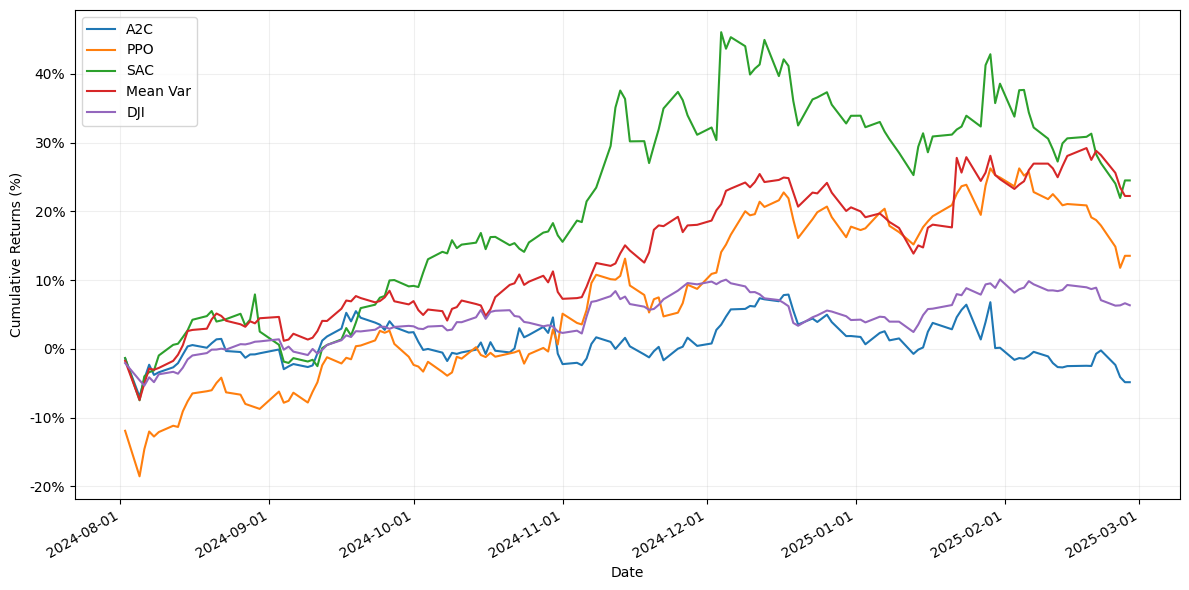

In [55]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Setting the figure size for the plot
plt.figure(figsize=(12, 6))

# Iterating through each strategy and plotting its cumulative returns
for strategy in strategies:
    if f'{strategy}_returns' in result.columns:
        # Make sure dates are properly parsed
        result.index = pd.to_datetime(result.index)
        
        # Extracting daily returns for the current strategy and converting to decimal format if necessary
        returns = result[f'{strategy}_returns'].dropna() + 1  # Adds 1 for using cumprod()
        
        # Calculating cumulative returns and converting to percentage
        cumulative_returns = (returns.cumprod() - 1) * 100  # Convert to percentage
        
        # Plotting cumulative returns with original colors
        plt.plot(cumulative_returns.index, cumulative_returns, label=strategy)

# Format y-axis as percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
plt.ylabel('Cumulative Returns (%)')
plt.xlabel('Date')

# Format x-axis dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Make sure dates are in the correct format and rotated
plt.gcf().autofmt_xdate()

# Adding title and legend
#plt.title('Cumulative Returns of DRL Strategies')
plt.legend(loc='upper left')

# Add grid with light gray color
plt.grid(True, linestyle='-', alpha=0.2)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Displaying the plot
plt.show()

### Saving results to CSV

In [56]:
import pickle

# For ppo
with open('results/6. PORTFOLIO/finrl_df_account_value_ppo.pkl', 'wb') as f:
    pickle.dump(df_account_value_ppo, f)
    
# For a2c
with open('results/6. PORTFOLIO/finrl_df_account_value_a2c.pkl', 'wb') as f:
    pickle.dump(df_account_value_a2c, f)

# For sac
with open('results/6. PORTFOLIO/finrl_df_account_value_sac.pkl', 'wb') as f:
    pickle.dump(df_account_value_sac, f)

# For mean var
with open('results/6. PORTFOLIO/finrl_mean_var.pkl', 'wb') as f:
    pickle.dump(MVO_result, f)

# For dji
with open('results/6. PORTFOLIO/finrl_dji.pkl', 'wb') as f:
    pickle.dump(dji, f)